In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, HTML

from pandas.plotting import scatter_matrix
from pandas.plotting import parallel_coordinates

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA as sklearnPCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.datasets.samples_generator import make_blobs
from sklearn.linear_model import Lasso

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.kernel_ridge import KernelRidge

import ridge_functions as rg
from sklearn import linear_model as lm
from sklearn import neighbors as ng

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# 1. Geração de um modelo para predição de coeficientes acadêmicos

Esta pesquisa tem como objetivo encontrar um modelo para prever o CRA de alunos do curso de ciência da computação na Universidade Federal de Campina Grande. Para isso, foram usados vários algoritmos para encontrar os melhores parâmetros do modelo escolhido. Para isso foi usada a **validação cruzada** que permite treinar o modelo usando como métrica o rmse no teste e não no treino. Separando o conjunto de dados em treino e teste e particionando o conjunto de treino em **k** partições onde **k-1** são usadas para treino realmente e a que "sobrou" é usada para teste. A cada iteração do algoritmo uma das **k** partições (diferente das já usadas anteriormente) é usada para teste e as outras **k-1** para treino.

In [4]:
df = pd.DataFrame(pd.read_csv("data/treino.csv"))
training = df.drop(["matricula", "cra"], axis = 1)
training.head()

Vetorial   LPT   P1   IC  LP1  Cálculo2  Discreta   P2  Grafos  \
0       8.6  10.0  9.0  9.1  8.6       8.4       8.3  8.8     8.2   
1       5.6   7.0  7.7  7.0  8.1       6.2       7.3  8.2     5.4   
2      10.0   9.8  7.9  9.6  8.3       8.7       8.8  9.5     9.2   
3       6.1   8.3  6.8  8.2  7.1       8.0       6.3  8.9     7.0   
4       8.8   9.3  5.0  8.5  5.1       5.0       5.8  7.1     5.4   

   Fís.Clássica  LP2  Cálculo1  
0           7.9  9.4       8.7  
1           7.7  8.9       7.0  
2           8.6  9.7       8.6  
3           8.5  9.0       7.8  
4           8.7  8.2       5.2

Os dados foram tratados para que valores nulos sejam substituídos pela média da variável.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1f9f3c950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb1f6b781d0>]], dtype=object)

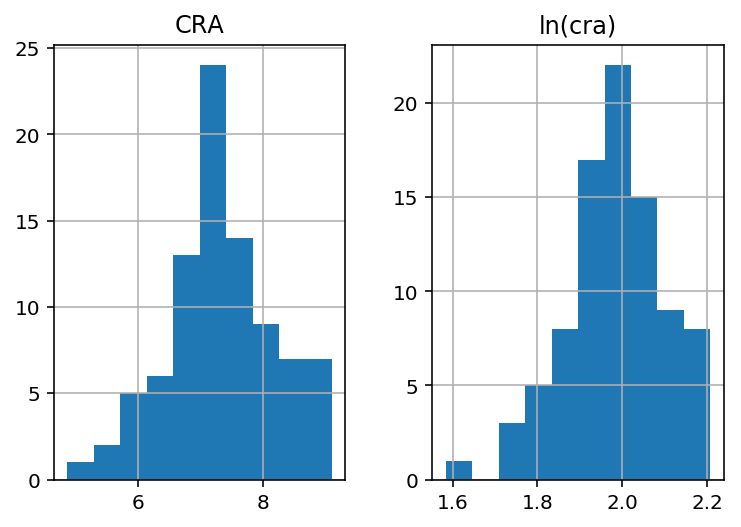

In [5]:
cra = pd.DataFrame({"CRA":df["cra"], "ln(cra)":np.log(df["cra"])})
cra.hist()

Os dados estão todos na mesma escala e por isso não será necessário transformá-los. O gráfico acima mostra a variável resposta "cra" em duas escalas. Ao mudar para outra escala como a logaritmica por exemplo, a distribuição fica viesada. Por isso é melhor deixar a variável na escala em que se encontra.

In [6]:
df.boxplot(return_type='axes')
plt.xticks(rotation=90)
plt.show()

Perceba que Física clássica é a disciplina em que as notas dos alunos estão mais concentradas em torno de um valor "único". Assim como a distribuição de Calculo2 é a mais "espalhada".

## 2.  1ª Parte - Seleção de um modelo preditivo de regressão

Os dados foram modelados usando vários algoritmos. Os modelos escolhidos foram modelos lineares usando a função Ridge e Lasso, e uma modelagem não paramétrica usando o KNN e Kernel Regression. O objetivo principal nesse estudo é descobrir quais os melhores hiperparâmetros para cada um dos modelos, capturar os rmses de cada modelo e comparar quais os melhores.

Nesta seção serão gerados modelos de **regressão linear** usando os mais diveros algoritmos como KNN Regression, Ridge e Lasso. Antes porém, é necessário saber quais as duas normas das funções custo para calcular os melhores parâmetros do modelo da função Lasso e Ridge.

A função lasso usa a norma $L1$ para calcular o melhor conjunto de parâmetros. Já a função Ridge usa a norma $L2$. Abaixo ambas as funções são listadas:

$L1 : \sum_{j=0}^N (w_j) = \|w\|$<br>
$L2 : \sum_{j=0}^N (w_j) ^ 2 = \|w\| ^ 2 $

Essas duas funções são somadas ao $RSS(w)$

## 2.1 Ridge

A modelagem usando a função Ridge tem como objetivo calcular um valor $\lambda$ para encontrar o melhor trade-off entre o **Bias** e a **variância** do modelo linear. O Bias indica o quanto o modelo está próximo dos valores reais no conjunto de treino e a variância é o quanto o modelo varia e estima mal para dados de teste. Abaixo a função Ridge é usada para encontrar um valor de $\lambda$ calculado de forma a minimizar o erro no conjunto de teste e não de treino. O modelo é contruído no **conjunto de treino**, mas validade usando um **conjunto de teste**, separado antes de executar o algoritmo.

In [9]:
X_train = training[:training.shape[0]]
Y = df.cra

In [10]:
alphas = [0.001, 0.01, 0.1, 0.5, 0.8, 1, 2, 3, 5, 10, 15, 30, 50, 150, 200]
cv_ridge = [rg.rmse_cv(Ridge(alpha = a), X_train, Y).mean()
            for a in alphas]

In [11]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

O $rmse$ decresce até certo ponto e depois começa a crescer novamente. O ponto de inflexão do gráfico(ponto onde o gráfico passa a crescer ao invés de decrescer e vice-versa) é o que determina o melhor $\lambda$. Para os dados dos alunos de computação, $\lambda = 50$.

In [12]:
cv_ridge

0.001      0.596630
0.010      0.596588
0.100      0.596178
0.500      0.594408
0.800      0.593135
1.000      0.592312
2.000      0.588465
3.000      0.585016
5.000      0.579084
10.000     0.568183
15.000     0.560822
30.000     0.549177
50.000     0.544341
150.000    0.558923
200.000    0.570768
dtype: float64

In [13]:
cv_ridge.min()

0.54434129996998615

Os parâmetros encontrados para $\lambda = 50$ estão listados na figura abaixo

In [47]:
best_ridge = Ridge(alpha = 50).fit(X_train, Y)

ridge_coef = pd.Series(best_ridge.coef_, index = X_train.columns)
print ridge_coef


Vetorial        0.085238
LPT             0.011249
P1              0.021903
IC              0.075748
LP1             0.031197
Cálculo2       -0.021966
Discreta        0.146459
P2              0.124889
Grafos          0.144591
Fís.Clássica    0.047563
LP2             0.005733
Cálculo1        0.026282
dtype: float64


O quanto cada coeficiente é representativo no modelo é mostrado no gráfico de barras abaixo. O resultado da execução do Ridge apontou a disciplina de "P2" como sendo a que mais influencia no cra final do aluno. As disciplinas de "Grafos" e "Discreta" também apresentaram um valor alto (se comparado aos outros coeficientes) e também influenciam bastante no "cra" final do aluno. Esse modelo será usado na II parte da pesquisa. Já as disciplinas de "LP2", "CálculoII" e "P1" apresentaram valores baixos o que indica baixa importância na previsão. Na próxima seção, a estimativa dos atributos foi feita novamente usando a função lasso e os resultados foram ligeiramente diferentes.

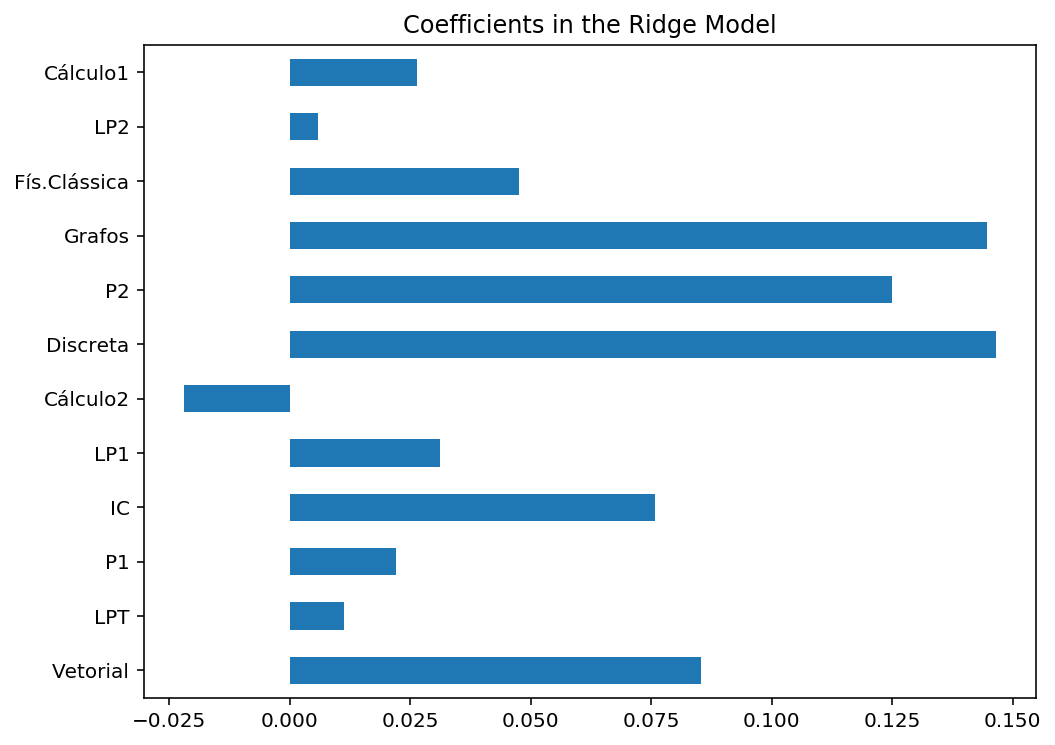

In [13]:
ridge_coef = pd.Series(best_ridge.coef_, index = X_train.columns)
plt.rcParams['figure.figsize'] = (8.0, 6.0)
ridge_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

O cruzamento dos dados de **previsão** do modelo e os valores reais não parecem formar um tipo de relação, conforme a figura abaixo. Aparentemente os dados estão muito espalhados e o erro seria alto para o melhor modelo gerado. Isso é bom, pois indica que o modelo gerado pela função Ridge consegue prever com uma certa precisão o CRA do aluno dados as notas dele nas disciplinas do primeiro período.

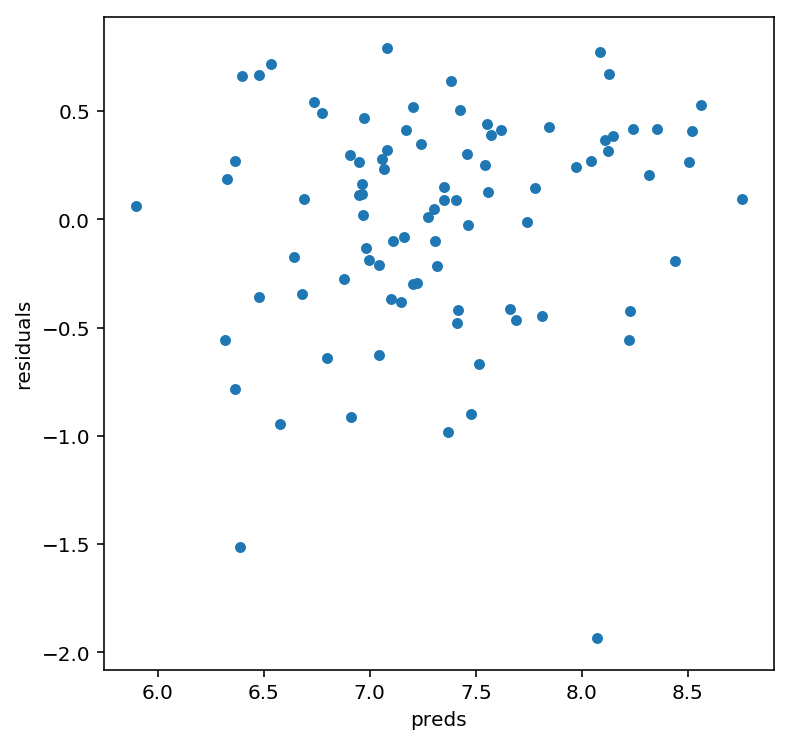

In [14]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":best_ridge.predict(X_train), "true":Y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# 2.2 Lasso

O custo da função $Lasso$ é dada por:

$custo = RSS(w) + \|w\|$

onde $RSS$ é o somatório dos resíduos para calcular o melhor vetor $w$ e $\|w\|$ é o somatório de todos os parâmetros. Quanto maior os parâmetros mais complexo o modelo. Quanto mais complexo é um modelo, menor é o Bias e maior a variância. Quando o modelo é simples as coisas se invertem, maior será o Bias e menor a variância até certo ponto pois pela simplicidade do modelo ele não será mais capaz de prever tão bem a não ser que seja um problema muito simples.

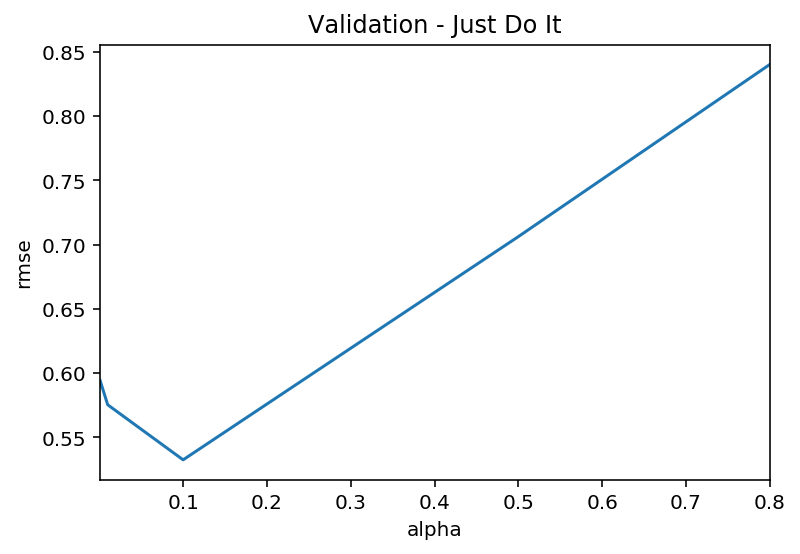

In [18]:
alphas = [0.001, 0.01, 0.1, 0.5, 0.8]
cv_lasso_rmses = [rg.rmse_cv(Lasso(alpha = a), X_train, Y).mean()
            for a in alphas]

cv_lasso_rmses = pd.Series(cv_lasso_rmses, index = alphas)
cv_lasso_rmses.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [19]:
cv_lasso_rmses

0.001    0.594216
0.010    0.575448
0.100    0.532605
0.500    0.706249
0.800    0.840175
dtype: float64

In [20]:
cv_lasso_rmses.min()

0.53260534451994335

O menor $rmse$ encontrado para a função $Lasso$ foi para $\lambda = 0.100$. Este será o hiperparâmetro usado para este modelo.

In [53]:
best_lasso = Lasso(alpha = 0.100).fit(X_train, Y)
lasso_coef = pd.Series(best_lasso.coef_, index = X_train.columns)
print ("Model parameters \n\nIntercept       {0}\n{1}".format(best_lasso.intercept_, lasso_coef))

Model parameters 

Intercept       3.05077284167
Vetorial        0.073961
LPT             0.000000
P1              0.000000
IC              0.017619
LP1             0.000000
Cálculo2       -0.000000
Discreta        0.172356
P2              0.135835
Grafos          0.188230
Fís.Clássica    0.000000
LP2             0.000000
Cálculo1        0.000000
dtype: float64


### 2.2.1 Modelo Lasso gerado pela bibliotecaScikit Learn

In [19]:
coef = pd.Series(best_lasso.coef_, index = X_train.columns)
print("A função Lasso selecionou " + str(sum(coef != 0)) + " variáveis e eliminou " +  str(sum(coef == 0)))

A função Lasso selecionou 5 variáveis e eliminou 7


In [20]:
display(best_lasso.coef_)

array([ 0.07396074,  0.        ,  0.        ,  0.01761909,  0.        ,
       -0.        ,  0.17235628,  0.13583547,  0.18822963,  0.        ,
        0.        ,  0.        ])

O processo de **simplificação** do modelo retornou 5 variáveis como sendo as mais "importantes". Das 5 selecionadas para representar o modelo com uma certa perda, a mais importante é a variável "Grafos", ou seja, as disciplinas de "Grafos", "Discreta", "P2", "Vetorial" e "IC" são as que mais influenciam no cra final do aluno, respecitivament eem sequência, segundo a função lasso para um $\lambda$ de aproximadamente $0.1$ com um rmse de aproximadamente $0.53$. Observe que a função Ridge também apontou as mesmas disciplinas como as mais influentes.

In [21]:
imp_coef = pd.concat([coef.sort_values().head(6),
                     coef.sort_values().tail(6)])
plt.rcParams['figure.figsize'] = (8.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

A função Lasso apresentou praticamente a mesma dispersão no cruzamento dos dados **reais** e de **previsão**. A semelhança mostra que não há nenhum padrão nos dados(a olho nu) e isso mostra que o modelo é bem representativo dos dados e consequentemente do problema.

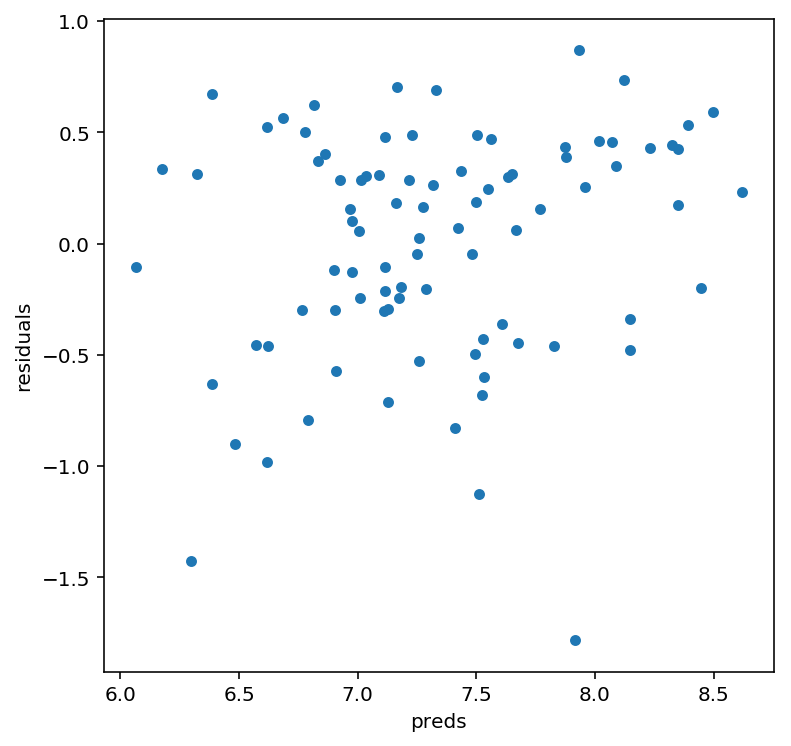

In [23]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":best_lasso.predict(X_train), "true":Y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## 2.3 KNN

O algoritmo *KNN* parte do princípio de classificar uma determinada observação baseada nos seus vizinhos mais próximos. O algoritmo não constrói um modelo, ele executa e "decide" a classificação no momento da execução dos testes. Porém, para construir uma boa instância é necessário encontrar quais os melhores parâmetros, por exemplo qual o melhor K? A maioria dos hiperparâmetros encontrados em modelos construídos usando aprendizagem de máquina, são encontrados usando a técnica de validação cruzada.

In [34]:
neighbors = range(1,25)
knn_model_rmses = [rg.rmse_cv(ng.KNeighborsRegressor(n_neighbors=n), X_train, Y).mean() for n in neighbors]

knn_model_rmses = pd.Series(knn_model_rmses, index = neighbors)
knn_model_rmses.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [35]:
knn_model_rmses

1     0.719987
2     0.650804
3     0.584325
4     0.587855
5     0.571910
6     0.553789
7     0.552580
8     0.525923
9     0.528171
10    0.530503
11    0.529273
12    0.529978
13    0.533946
14    0.540486
15    0.548094
16    0.557475
17    0.554018
18    0.562399
19    0.563477
20    0.574269
21    0.579867
22    0.585201
23    0.589300
24    0.593140
dtype: float64

In [36]:
knn_model_rmses.min()

0.52592269103356193

Como o $KNN$ é um algoritmo de regressão não paramétrico, ou seja, não se trata de um modelo com parâmetros a serem definidos, então não há nenhum coeficiente a ser calculado. A única coisa que modelo precisa para fzer as predições é do melhor $K$ que miniminize o $rmse$.

In [37]:
best_knn_regression = ng.KNeighborsRegressor(n_neighbors=8).fit(X_train, Y)
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":best_knn_regression.predict(X_train), "true":Y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## 2.4 Kernel Regression (RIDGE)

OBS: Este algoritmo foi selecionado por não ser possível tunar hiperparãmetros no KNN Kernel Regression.

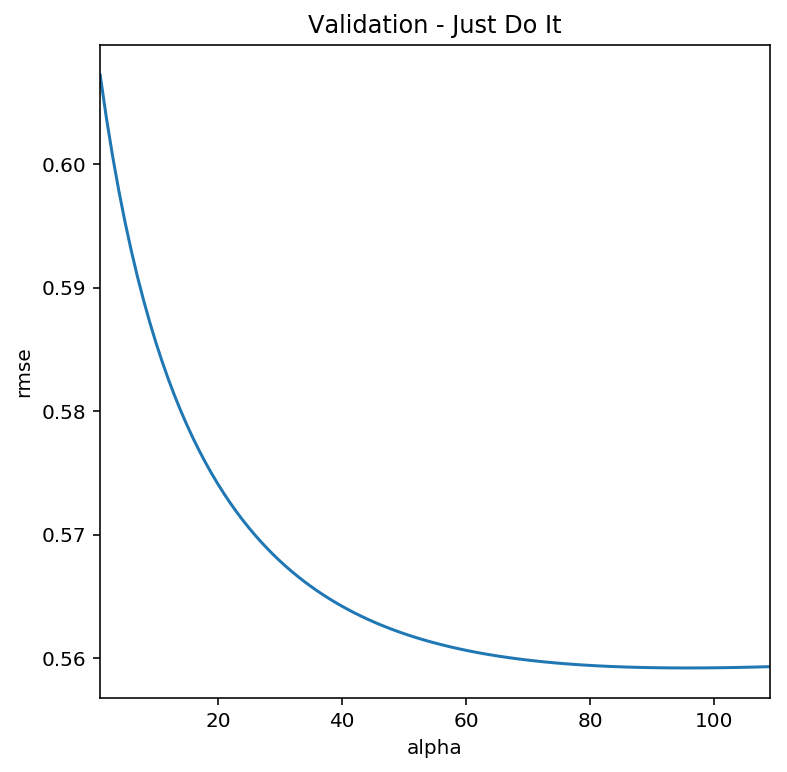

In [38]:
neighbors = range(1,110)
knn_kernel_ridge_rmses = [rg.rmse_cv(KernelRidge(alpha=n), 
                              X_train, Y).mean() for n in neighbors]

knn_kernel_ridge_rmses = pd.Series(knn_kernel_ridge_rmses, index = neighbors)
knn_kernel_ridge_rmses.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [39]:
knn_kernel_ridge_rmses

1      0.607206
2      0.603754
3      0.600659
4      0.597867
5      0.595335
6      0.593027
7      0.590916
8      0.588976
9      0.587189
10     0.585536
11     0.584005
12     0.582583
13     0.581259
14     0.580023
15     0.578869
16     0.577788
17     0.576775
18     0.575824
19     0.574930
20     0.574089
21     0.573297
22     0.572550
23     0.571844
24     0.571178
25     0.570548
26     0.569953
27     0.569389
28     0.568854
29     0.568348
30     0.567868
         ...   
80     0.559417
81     0.559389
82     0.559364
83     0.559340
84     0.559319
85     0.559301
86     0.559284
87     0.559269
88     0.559256
89     0.559245
90     0.559235
91     0.559227
92     0.559221
93     0.559217
94     0.559214
95     0.559212
96     0.559212
97     0.559213
98     0.559215
99     0.559219
100    0.559224
101    0.559230
102    0.559238
103    0.559246
104    0.559255
105    0.559266
106    0.559277
107    0.559290
108    0.559303
109    0.559317
Length: 109, dtype: floa

In [40]:
knn_kernel_ridge_rmses.min()

0.55921180379400115

Para os valores de $\lambda = 95 e \lambda = 96$ o valor do rmse foi o mesmo e o menor dentre todos os valores tunados. 

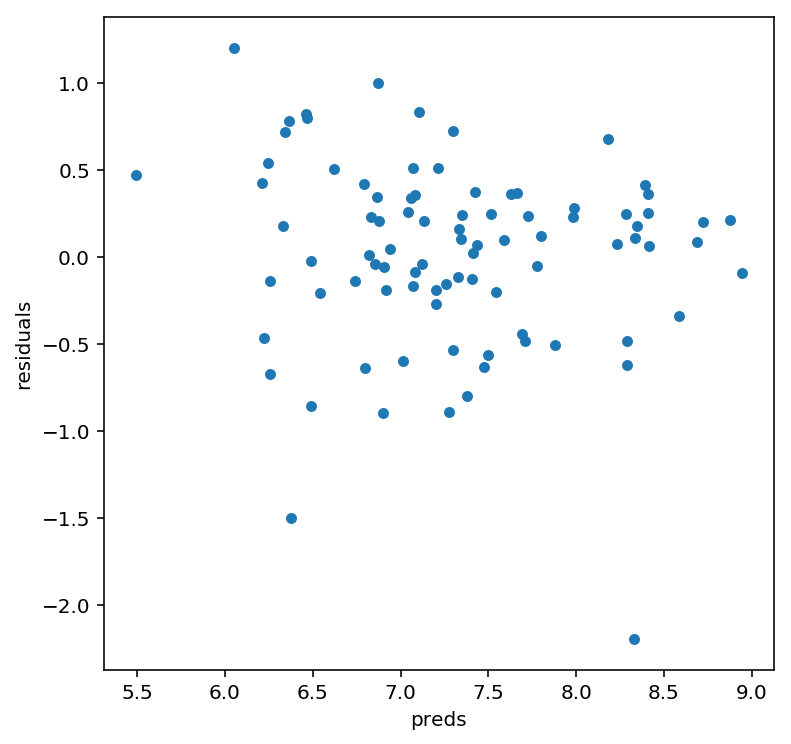

In [41]:
best_kernel_ridge = KernelRidge(alpha=95).fit(X_train, Y)
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":best_kernel_ridge.predict(X_train), "true":Y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## 2.5 Modelo sem regularização

Um modelo sem regularização, é um modelo linear comum que não passa por nenhum ajuste para encontrar o melhor trade-off entre Bias e variância e melhorias usando a tunagem de hiperparâmetros escolhidos usando validação cruzada.

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y, test_size=0.30, random_state=42)
linear_regression = lm.LinearRegression().fit(x_train, y_train)

cra_y_pred = linear_regression.predict(x_test)

print("Intercept : {0}".format(linear_regression.intercept_))
# The coefficients
print('Coefficients: \n', linear_regression.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, cra_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, cra_y_pred))

Intercept : 1.39586651415
('Coefficients: \n', array([ 0.12745313, -0.03270341,  0.0004779 ,  0.13331351,  0.04881361,
        0.00283962,  0.15121482,  0.2190797 ,  0.21073296, -0.04215886,
       -0.00494777, -0.01057998]))
Mean squared error: 0.48
Variance score: -0.46


# 3. 2ª Parte - testando os modelos gerados

In [43]:
df_test = pd.DataFrame(pd.read_csv("data/teste.csv"))
test = df_test.drop(["matricula", "cra"], axis = 1)
test.head()

Cálculo1  Vetorial  LPT   P1   IC  LP1  Cálculo2  Discreta   P2  Grafos  \
0       7.0       7.0  5.2  5.4  7.9  6.4       5.0       5.1  6.4     7.1   
1       7.0       7.0  7.2  7.9  8.7  7.7       6.5       7.9  8.7     6.5   
2       7.3       5.0  8.3  8.1  7.0  7.4       5.0       5.9  7.3     5.6   
3       7.0       6.8  6.4  7.0  8.6  8.2       6.3       8.0  7.9     5.4   
4       7.8       7.4  7.0  7.0  8.7  7.1       7.3       8.2  8.1     7.5   

   Fís.Clássica  LP2  
0           7.0  7.1  
1           7.2  9.0  
2           5.0  7.1  
3           9.0  8.9  
4           7.4  8.0

Os modelos escolhidos na seção anterior como sendo os melhores modelos por apresentarem os melhores valores para os rmses serão testados nesta seção e saber qual o melhor deles.

### Ridge

In [44]:
X_test = test[:test.shape[0]]
Y_test = df_test.cra

**RMSE mínimo**

In [45]:
cv_ridge.min()

0.54434129996998615

In [49]:
ridge_coef = pd.Series(best_ridge.coef_, index = X_train.columns)
print ("Model parameters \n\nIntercept       {0}\n{1}".format(best_ridge.intercept_, ridge_coef))

Model parameters 

Intercept       2.1371953153
Vetorial        0.085238
LPT             0.011249
P1              0.021903
IC              0.075748
LP1             0.031197
Cálculo2       -0.021966
Discreta        0.146459
P2              0.124889
Grafos          0.144591
Fís.Clássica    0.047563
LP2             0.005733
Cálculo1        0.026282
dtype: float64


In [50]:
cra_ridge_predict = best_ridge.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, cra_ridge_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, cra_ridge_predict))

MSE_VS=[]
MSE_VS.append(mean_squared_error(Y_test, cra_ridge_predict) / r2_score(Y_test, cra_ridge_predict))
print('coeficient MSE/VS: %.2f'% MSE_VS[0])

Mean squared error: 0.13
Variance score: 0.70
coeficient MSE/VS: 0.19


### Lasso

**RMSE mínimo**

In [51]:
cv_lasso_rmses.min()

0.53260534451994335

In [55]:
print ("Model parameters \n\nIntercept       {0}\n{1}".format(best_lasso.intercept_, lasso_coef))

Model parameters 

Intercept       3.05077284167
Vetorial        0.073961
LPT             0.000000
P1              0.000000
IC              0.017619
LP1             0.000000
Cálculo2       -0.000000
Discreta        0.172356
P2              0.135835
Grafos          0.188230
Fís.Clássica    0.000000
LP2             0.000000
Cálculo1        0.000000
dtype: float64


In [56]:
cra_lasso_predict = best_lasso.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, cra_lasso_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, cra_lasso_predict))

MSE_VS.append(mean_squared_error(Y_test, cra_lasso_predict) / r2_score(Y_test, cra_lasso_predict))
print('coeficient MSE/VS: %.2f'% MSE_VS[1])

Mean squared error: 0.15
Variance score: 0.68
coeficient MSE/VS: 0.22


### KNN regression

**RMSE mínimo**

In [54]:
knn_model_rmses.min()

0.52592269103356193

In [57]:
cra_knn_reg_predict = best_knn_regression.predict(X_test)

print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, cra_knn_reg_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, cra_knn_reg_predict))

MSE_VS.append(mean_squared_error(Y_test, cra_knn_reg_predict) / r2_score(Y_test, cra_knn_reg_predict))
print('coeficient MSE/VS: %.2f'% MSE_VS[2])

Mean squared error: 0.19
Variance score: 0.57
coeficient MSE/VS: 0.34


### Kernel Ridge Regression

**RMSE mínimo**

In [58]:
knn_kernel_ridge_rmses.min()

0.55921180379400115

In [59]:
cra_knn_ridge_reg_predict = best_kernel_ridge.predict(X_test)

print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, cra_knn_ridge_reg_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, cra_knn_ridge_reg_predict))

MSE_VS.append(mean_squared_error(Y_test, cra_knn_ridge_reg_predict) / r2_score(Y_test, cra_knn_ridge_reg_predict))
print('coeficient MSE/VS: %.2f'% MSE_VS[3])

Mean squared error: 0.24
Variance score: 0.47
coeficient MSE/VS: 0.51


### Modelo sem regularização

In [60]:
cra_without_reg_predict = linear_regression.predict(X_test)

print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, cra_without_reg_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, cra_without_reg_predict))

MSE_VS.append(mean_squared_error(Y_test, cra_without_reg_predict) / r2_score(Y_test, cra_without_reg_predict))
print('coeficient MSE/VS: %.2f'% MSE_VS[4])

Mean squared error: 0.15
Variance score: 0.67
coeficient MSE/VS: 0.22


Os modelos que mais acertaram foram os modelos sem regularização, Lasso e Ridge. O *KNN regression* e o *kernel ridge* foram os que mais erraram. Porém, ainda foi calculado o *score da variância* e *mean square error* 
no conjunto de teste. O modelo escolhido através da métrica rmse, foi o *KNN Regression* que apresentou o *rmse mínimo* de aproximadamente 0.52. Usando outra métrica no conjunto de teste o *KNN* também é o melhor. Essa métrica é o coeficiente entre o *MSE* e o *variance_score*. 

$MSE VS = \frac{MSE}{variance-score}$

A média entre os MSE_VS foi de aproximadamente: 

In [61]:
mean = sum(MSE_VS) / len(MSE_VS)
mean

0.29690166899616643

e o valor mais próximo da média foi o do KNN de aproximadamente 0.34. Os outros apresentaram uma "distância" maior da média. Com isso, para este conjunto de dados o melhor modelo construído neste foi o *KNN regression*, com K = 8 e por isso foi o modelo escolhido para prever o CRA dos alunos do primeiro período do curso de Ciência da Computação na UFCG.